In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.parser import parse

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

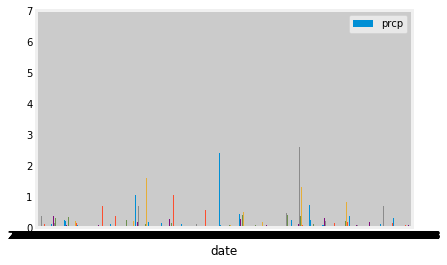

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# Calculate the date 1 year ago from the last data point in the database
year_from_last = parse(latest_date[0]) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > str(year_from_last)).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column and Sort the dataframe by date
year_data_df = pd.DataFrame(year_data).sort_values(by=['date'])
year_data_df.plot.bar(x='date', y='prcp', rot=0)
# Use Pandas Plotting with Matplotlib to plot the data


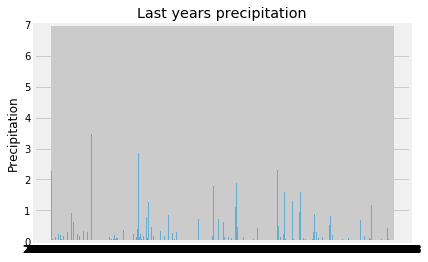

In [13]:
#Graph with matplotlib
dates = year_data_df['date']
y_pos = np.arange(len(dates))
precip = year_data_df['prcp']
 
plt.bar(y_pos, precip, align='center', alpha=0.5)
plt.xticks(y_pos, dates)
plt.ylabel('Precipitation')
plt.title('Last years precipitation')
 
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()

,prcp,tobs
count,2015.000000,2223.000000
mean,0.176462,74.578947
std,0.460288,4.612232
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id,Station.station).all()
for station in stations:
    print(station)

(1, 'USC00519397')
(2, 'USC00513117')
(3, 'USC00514830')
(4, 'USC00517948')
(5, 'USC00518838')
(6, 'USC00519523')
(7, 'USC00519281')
(8, 'USC00511918')
(9, 'USC00516128')


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_info = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active[0][0]).all()
most_active_info_df = np.array(most_active_info)
print(f"The lowest temperature recorded is {most_active_info_df.min()}\nThe highest temperature recorded is {most_active_info_df.max()}\nThe average tempature recorded is {most_active_info_df.mean()} ")

The lowest temperature recorded is 54.0
The highest temperature recorded is 85.0
The average tempature recorded is 71.66378066378067 


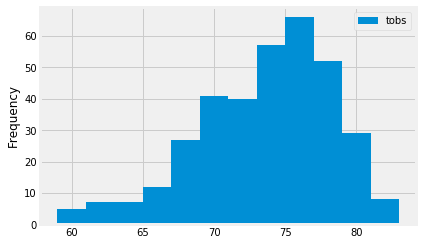

In [18]:
# Choose the station with the highest number of temperature observations.
by_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
highest_temps_station = by_temps[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_station_info = session.query(Measurement.tobs).\
    filter(Measurement.station == highest_temps_station).\
    filter(Measurement.date > str(year_from_last)).all()
highest_temp_station_info_df = pd.DataFrame(highest_temp_station_info)
highest_temp_station_info_df.plot.hist(bins=12)


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2015-07-19'
trip_end = parse(trip_start) + dt.timedelta(days=14)
trip_start_lastyear = parse(trip_start) - dt.timedelta(days=365)
trip_end_lastyear = trip_start_lastyear + dt.timedelta(days=14)
trip_data = calc_temps(trip_start_lastyear,trip_end_lastyear)
trip_start_lastyear

datetime.datetime(2014, 7, 19, 0, 0)

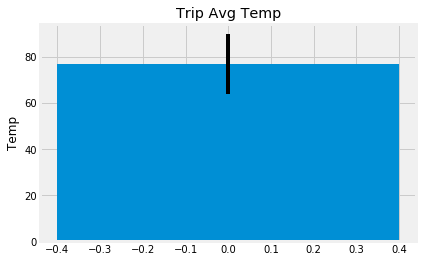

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = trip_data[0][1]
y_posi = np.arange(0,1,1)
y_err = [trip_data[0][2] - trip_data[0][0]]
plt.bar(y_posi, x,yerr=y_err)
plt.ylabel('Temp')
plt.title('Trip Avg Temp')
 
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station,Measurement.date, Measurement.prcp, Station.name, Station.latitude, Station.longitude).\
    filter(Measurement.date >= trip_start_lastyear - dt.timedelta(days=1)).\
    filter(Measurement.date <= trip_end_lastyear).\
    group_by(Measurement.station, Measurement.date).\
    order_by(Measurement.prcp.desc()).all()
    
rainfall_df = pd.DataFrame(rainfall)
rainfall_df.to_csv('Data/rainfall.csv')


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
